# パーセプトロン

## サンプルデータ

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import multivariate_normal

In [2]:
N1 = 20 # クラス t=+1 のデータ数
Mu1 = [15, 10] # クラス t=+1 の中心座標
N2 = 30 # クラス t=+2 のデータ数
Mu2 = [0, 0] # クラス t=+2 の中心座標

Variances = [15, 30] #両クラス共通の分散(2種類の分散で計算を実施)

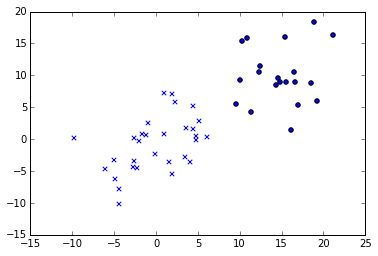

In [3]:
# データセット {x_n, y_n, type_n} を容易
def prepare_dataset(variance):
    cov1 = np.array([[variance, 0], [0, variance]])
    cov2 = np.array([[variance, 0], [0, variance]])
    
    df1 = DataFrame(multivariate_normal(Mu1, cov1, N1), columns=['x', 'y'])
    df1['type' ] = 1
    df2 = DataFrame(multivariate_normal(Mu2, cov2, N2), columns=['x', 'y'])
    df2['type' ] = -1
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

set = prepare_dataset(Variances[0])
set1 = set[set['type'] == 1]
set2 = set[set['type'] == -1]
plt.scatter(set1.x, set1.y, marker='o')
plt.scatter(set2.x, set2.y, marker='x')
    

$t=\pm-1$の2種類の属性を持つデータを分類する直線を発見する。直線を決定するアルゴリズムとして、誤差関数を用いて、誤差を最小にするパラメーターを決定するために確率的勾配降下法(stochastic gradient descent, SGD)を利用する。

## 確率的勾配降下法のアルゴリズム

### 平面を分割する直線の方程式

パラメトリックモデルのステップ1、パラメーターを含むモデル(数式)を設定する。

$(x, y)$平面を分割する直線として、以下の線形関数$f(x, y)$を用意する。

$$
f(x, y) = w_0 + w_1 x + w_2 + t \tag{4.1}
$$

この時$(x, y)$平面を分割する直線は、次式で表される。

$$
f(x, y) = 0 \tag{4.2}
$$

ここでは次のルールで、データを分類する。

$$
f(x, y) > 0 \Rightarrow t = +1 \tag{4.3}
$$

$$
f(x, y) < 0 \Rightarrow t = -1 \tag{4.4}
$$

このとき、トレーニングセットとして与えられたデータ$\left\{ (x_n, y_n, t_n) \right\}_{n=1}^N$について、それぞれ正しく分類されているかは、以下のルールで判定することができる。

$$
f(x_n, y_n) \times t_n > 0 : 正解 \tag{4.5}
$$

$$
f(x_n, y_n) \times t_n < 0 : 不正解 \tag{4.6}
$$

すべての$(x_n, y_n, t_n)$について、(4.5)が成り立つような直線、すなわち、(4.1)の係数$(w_0, w_1, w_2)$を見つけることが目標になる。

### 誤差関数による分類結果の評価

パラメトリックモデルのステップ2、パラメーターを評価する基準を決める。

パラメーターの評価基準として、正しく分類できなかった点、すなわち、(4.6)が成り立つ点が合った場合に、これを誤差―誤って判定したペナルティとする。ペナルティの合計値が小さいほど正しい分類に近いものと考える。

正しく分類できなかった任意の点の誤差として以下値を採用する。

$$
E_n = |f(x_n, y_n)| \tag{4.7}
$$

分類の誤差は、誤って分類された点の誤差を合計したもので、以下$E$となる。

$$
E = \sum_n E_n = \sum_n |f(x_n, y_n)| \tag{4.8}
$$

(4.8)について、(4.6)を満たすので以下の関係式が成り立つ。

$$
|f(x_n, y_n)| = -f(x_n, y_n) \times t_n \tag{4.9}
$$

(4.9)と(4.1)を用いて(4.8)は次のように表せる。

$$
E = - \sum_n (w_0 + w_1x_n + w_2y_n)t_n \tag{4.10}
$$

あるいはベクトルを用いて以下のとおり表せる。

$$
E = - \sum_n t_n \mathbf{w}^\mathrm{T} \phi_n \tag{4.11}
$$

ここで$\mathbf{w}$と$\phi_n$は次で定義されるベクトルである。

$$
\mathbf{w} = \left(
    \begin{array}{c}
    w_0 \\
    w_1 \\
    w_2 \\
    \end{array}
\right) \tag{4.12}
$$

$$
\mathbf{\phi_n} = \left(
    \begin{array}{c}
    1 \\
    x_n \\
    y_n \\
    \end{array}
\right) \tag{4.13}
$$

ここで$\phi_n$の第一成分$1$は、係数$w_0$に対する成分で、バイアス項と呼ばれる。

### 勾配ベクトルによるパラメーターの修正

パラメトリックモデルのステップ3、最良の評価を与えるパラメーターを決定する。

(4.11)で計算される誤差$E$を最小にするパラメーター$\mathbf{w}$を求める。

(4.11)の勾配ベクトルが$\mathbf{0}$になるようにしたい、

$$
\nabla E(\mathbf{w}) = - \sum_n t_n \mathbf{\phi_n} = 0 \tag{4.15}
$$

ここで勾配ベクトルは

$$
\nabla E(\mathbf{w}) = \left(
    \begin{array}{c}
    \partial{E} / \partial{w_0} \\
    \partial{E} / \partial{w_1} \\
    \partial{E} / \partial{w_2} \\
    \end{array}
\right) \tag{4.16}
$$

純粋な式変換で$\mathbf{w}$を求めることは不可能なので、数値計算を用いて$\mathbf{w}$の値を修正しながら、誤差$E$がなるべく小さくなるものを求める。

$\mathbf{w}$の値を任意に決めた際に、その点で計算される勾配ベクトル$\nabla E(\mathbf{w})$の反対方向、すなわち、次式の方向に$\mathbf{w}$を修正することで誤差$E(\mathbf{w})$の値を小さくすることが可能である。

$$
- \nabla E(\mathbf{w}) = \sum_n t_n \phi_n \tag{4.20}
$$

勾配ベクトルの反対方向にパラメーターを修正して、「誤差の谷」を降っていくという考え方から、「確率的勾配降下法」の「勾配降下」という言葉が来ている。

(4.20)の右辺は、「正しく分類されなかった点」についてそれぞれ$t_n\phi_n$を計算して合計することを意味するが、データ数が膨大にある場合にはこの計算に時間がかかる。そのため、正しく分類されていない点$(x_n, y_n)$をどれか一つ選んで、とりあえずその分だけパラメーターを修正し、

$$
\mathbf{w}_{new} = \mathbf{w}_{old} + t_n\phi_n \tag{4.21}
$$

得られた新しい$\mathbf{w}$の元で、別の正しく分類されていない点を一つ選んで同様に(4.21)の修正を行う、という行為を繰り返す。これが「確率的」の所以。

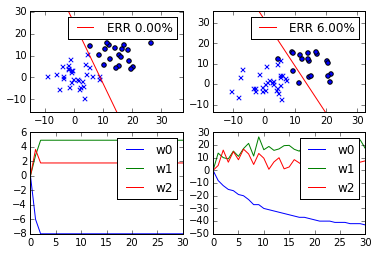

In [4]:
fig = plt.figure()

# Perceptronのアルゴリズム(確率的勾配降下法)を実行
def run_simulation(variance, data_graph, param_graph):
    train_set = prepare_dataset(variance)
    train_set1 = train_set[train_set['type'] == 1]
    train_set2 = train_set[train_set['type'] == -1]
    ymin, ymax = train_set.y.min() - 5, train_set.y.max() + 10
    xmin, xmax = train_set.x.min() - 5, train_set.x.max() + 10
    data_graph.set_ylim([ymin - 1, ymax + 1])
    data_graph.set_xlim([xmin - 1, xmax + 1])
    data_graph.scatter(train_set1.x, train_set1.y, marker='o')
    data_graph.scatter(train_set2.x, train_set2.y, marker='x')
    
    #  パラメーターの初期値とbias項の設定
    w0 = w1 = w2 = 0.0
    bias = 0.5 * (train_set.x.mean() + train_set.y.mean())
    
    # Iterationを30回実施
    paramhist = DataFrame([[w0, w1, w2]], columns=['w0', 'w1', 'w2'])
    for i in range(30):
        for index, point in train_set.iterrows():
            x, y, type = point.x, point.y, point.type
            if type * (w0 * bias + w1 * x + w2 * y) <= 0:
                w0 += type * 1
                w1 += type * x
                w2 += type * y
        paramhist = paramhist.append(
                                Series([w0, w1, w2], ['w0', 'w1', 'w2']),
                                ignore_index=True)
    
    # 判定誤差の計算
    err = 0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        if type * (w0 * bias + w1 * x + w2 * y) <= 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    # 結果の表示
    linex = np.arange(xmin - 5, xmax + 5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    data_graph.plot(linex, liney, label=label, color='r')
    data_graph.legend(loc=1)
    paramhist.plot(ax=param_graph)
    param_graph.legend(loc=1)

# 2種類の分散で実行
for c, variance in enumerate(Variances):
    subplots1 = fig.add_subplot(2, 2, c + 1)
    subplots2 = fig.add_subplot(2, 2, c + 2 + 1)
    run_simulation(variance, subplots1, subplots2)

ここで$\phi_n$のバイアス項の値として

$$
\frac{1}{2N}\sum_{n=1}^N(x_n + y_n)
$$

を採用している。試行一回ごとに$w_0$はバイアス項の分だけ変化するため、このようにバイアス項の値を適切に調整することでアルゴリズムの収束速度を改善することができる。

### バイアス項の幾何学的な意味